# Function approximation with linear models and neural network
* Are Linear models sufficient for approximating transcedental functions? What about polynomial functions?
* Do neural networks perform better in those cases?
* Does the depth of the neural network matter?
* Are neural network models better when the non-linearity grows (like an extended time series)?

### Import basic libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Global variables for the program

In [58]:
N_points = 75 # Number of points for constructing function
x_min = 1 # Min of the range of x (feature)
x_max = 15 # Max of the range of x (feature)
noise_mean = 0 # Mean of the Gaussian noise adder
noise_sd = 10 # Std.Dev of the Gaussian noise adder
test_set_fraction = 0.2

### Generate feature and output vector following a non-linear function
The ground truth or originating function is as follows:

$$ y=f(x)= (20x+3x^2+0.1x^3).sin(x).e^{-0.1x}+\psi(x) $$

$$ {OR} $$

$$ y=f(x)= (20x+3x^2+0.1x^3)+\psi(x) $$

$${where,}\ \psi(x) : {\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}\;e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}} $$

In [59]:
# Definition of the function with exponential and sinusoidal terms
def func_trans(x):
    result = (20*x+3*x**2+0.1*x**3)*np.sin(x)*np.exp(-0.1*x)
    return (result)

In [60]:
# Definition of the function without exponential and sinusoidal terms i.e. just the polynomial
def func_poly(x):
    result = 20*x+3*x**2+0.1*x**3
    return (result)

In [61]:
# Densely spaced points for generating the ideal functional curve
x_smooth = np.array(np.linspace(x_min,x_max,501))

# Use one of the following
y_smooth = func_trans(x_smooth)
#y_smooth = func_poly(x_smooth)

In [62]:
# Linearly spaced sample points
X=np.array(np.linspace(x_min,x_max,N_points))

In [63]:
# Added observational/measurement noise
noise_x = np.random.normal(loc=noise_mean,scale=noise_sd,size=N_points)

In [64]:
# Observed output after adding the noise
y = func_trans(X)+noise_x

In [65]:
# Store the values in a DataFrame
df = pd.DataFrame(data=X,columns=['X'])
df['Ideal y']=df['X'].apply(func_trans)
df['y']=y
df.head()

,X,Ideal y,y
0,1.000000,17.588211,-0.320812
1,1.189189,23.232586,33.512526
2,1.378378,28.672889,38.933591
3,1.567568,33.434022,38.551916
4,1.756757,37.046351,43.433369


### Plot the function(s), both the ideal characteristic and the observed output (with process and observation noise)

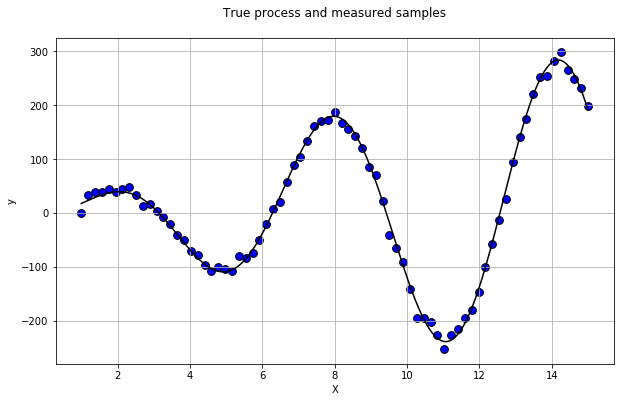

In [66]:
df.plot.scatter('X','y',title='True process and measured samples\n',
                grid=True,edgecolors=(0,0,0),c='blue',s=60,figsize=(10,6))
plt.plot(x_smooth,y_smooth,'k')

### Import scikit-learn librares and prepare train/test splits

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import column_or_1d

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=test_set_fraction)

X_train=X_train.values.reshape([X_train.size,1])
y_train=y_train.values.reshape([y_train.size,1])
X_test=X_test.values.reshape([X_test.size,1])
y_test=y_test.values.reshape([y_test.size,1])

#X_train=X_train.reshape(-1,1)
#y_train=y_train.reshape(-1,1)
#X_test=X_test.reshape(-1,1)
#y_test=y_test.reshape(-1,1)

from sklearn import preprocessing
X_scaled = preprocessing.scale(X_train)
y_scaled = preprocessing.scale(y_train)

### Polynomial model with LASSO/Ridge regularization (pipelined) with lineary spaced samples
** This is an advanced machine learning method which prevents over-fitting by penalizing high-valued coefficients i.e. keep them bounded **

In [69]:
# Regression model parameters
ridge_alpha = tuple([10**(x) for x in range(-3,0,1) ]) # Alpha (regularization strength) of ridge regression
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000

# Min and max degree of polynomials features to consider
degree_min = 2
degree_max = 8

D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

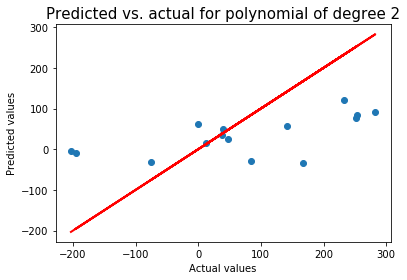

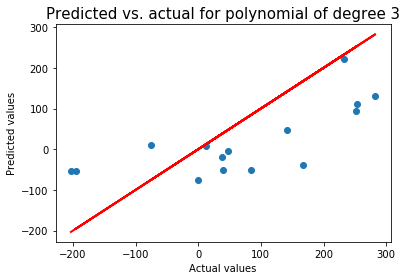

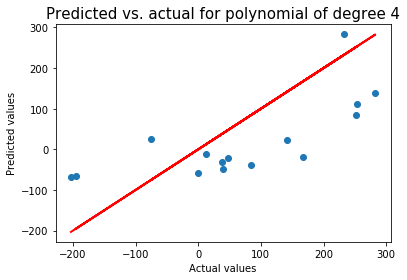

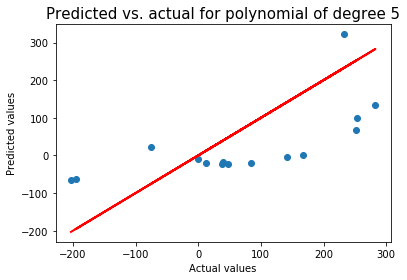

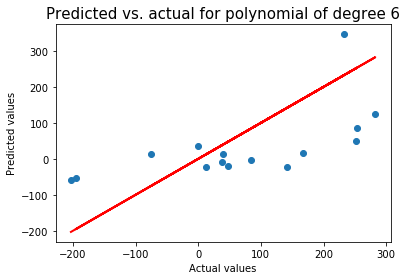

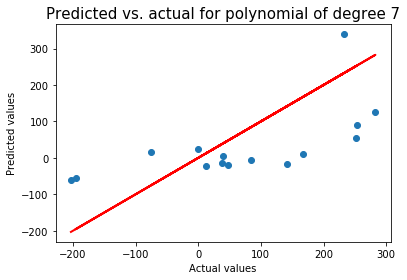

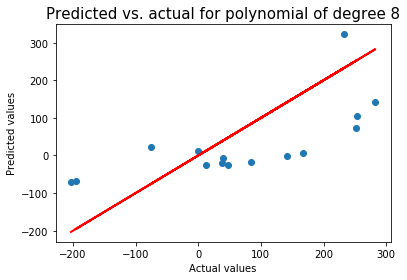

In [70]:
linear_sample_score = []
poly_degree = []
rmse=[]
t_linear=[]
import time
for degree in range(degree_min,degree_max+1):
    t1=time.time()
    #model = make_pipeline(PolynomialFeatures(degree), RidgeCV(alphas=ridge_alpha,normalize=True,cv=5))
    model = make_pipeline(PolynomialFeatures(degree), LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha, 
                                                                  max_iter=lasso_iter,normalize=True,cv=5))
    #model = make_pipeline(PolynomialFeatures(degree), LinearRegression(normalize=True))
    model.fit(X_train, column_or_1d(y_train, warn=False))
    t2=time.time()
    t = t2-t1
    t_linear.append(t)
    y_pred = np.array(model.predict(X_train))
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    linear_sample_score.append(test_score)
    rmse.append(RMSE)
    poly_degree.append(degree)
    #print("Test score of model with degree {}: {}\n".format(degree,test_score))
       
    plt.figure()
    plt.title("Predicted vs. actual for polynomial of degree {}".format(degree),fontsize=15)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.scatter(y_test,test_pred)
    plt.plot(y_test,y_test,'r',lw=2)

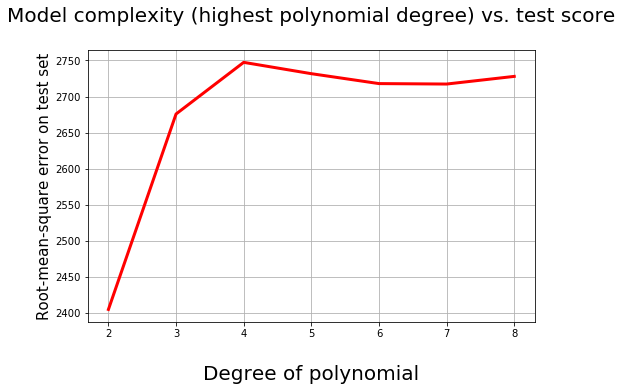

In [71]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.plot(poly_degree,rmse,lw=3,c='red')
plt.title("Model complexity (highest polynomial degree) vs. test score\n",fontsize=20)
plt.xlabel ("\nDegree of polynomial",fontsize=20)
plt.ylabel ("Root-mean-square error on test set",fontsize=15)

In [72]:
df_score = pd.DataFrame(data={'degree':[d for d in range(degree_min,degree_max+1)],
                              'Linear sample score':linear_sample_score})

In [73]:
# Save the best R^2 score
r2_linear = max(linear_sample_score)
print("Best R^2 score for linear polynomial degree models:",r2_linear)

Best R^2 score for linear polynomial degree models: 0.413261390008


In [74]:
t_linear=np.array(t_linear)
time_linear=np.sum(t_linear)

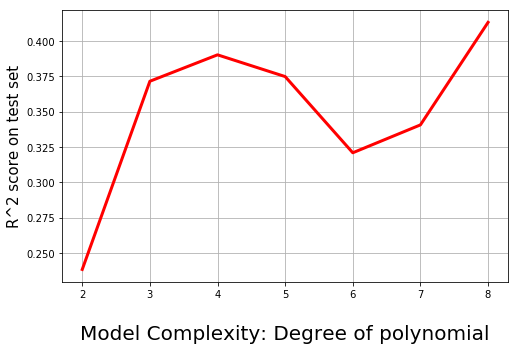

In [75]:
plt.figure(figsize=(8,5))
plt.grid(True)
plt.plot(poly_degree,linear_sample_score,lw=3,c='red')
plt.xlabel ("\nModel Complexity: Degree of polynomial",fontsize=20)
plt.ylabel ("R^2 score on test set",fontsize=15)

## Neural network for regression

### Import and declaration of variables

In [76]:
import tensorflow as tf

In [77]:
learning_rate = 0.00001
training_epochs = 100000

n_input = 1  # Number of features
n_output = 1  # Regression output is a number only

n_hidden_layer = 70 # layer number of features

### Weights and bias variable

In [78]:
# Store layers weight & bias as Variables classes in dictionaries
weights = {
    'hidden_layer': tf.Variable(tf.random_normal([n_input, n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer, n_output]))
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal([n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

In [79]:
print("Shape of the weights tensor of hidden layer:",weights['hidden_layer'].shape)
print("Shape of the weights tensor of output layer:",weights['out'].shape)
print("--------------------------------------------------------")
print("Shape of the bias tensor of hidden layer:",biases['hidden_layer'].shape)
print("Shape of the bias tensor of output layer:",biases['out'].shape)

Shape of the weights tensor of hidden layer: (1, 70)
Shape of the weights tensor of output layer: (70, 1)
--------------------------------------------------------
Shape of the bias tensor of hidden layer: (70,)
Shape of the bias tensor of output layer: (1,)


In [80]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    w=sess.run(weights['hidden_layer'])
    b=sess.run(biases['hidden_layer'])
print("Weight tensor initialized randomly\n---------------------------------------\n",w)
print("Bias tensor initialized randomly\n---------------------------------------\n",b)
sess.close()

Weight tensor initialized randomly
---------------------------------------
 [[ 0.53039408 -0.95315021 -0.58208454  1.33911347  0.12524173  0.43669453
   0.02140208 -0.79802245  1.50922418  3.05878258  0.77749109  2.23893046
  -0.42482486  0.96619624  0.62797046  0.73265195 -0.24405386 -1.02413714
   0.91995788 -1.75857949 -0.59325337  1.59078193 -0.41172567 -0.93912411
  -0.20444012 -1.44005561 -0.40195972  0.10385959  0.82684338  0.36135781
   0.25572562 -1.12031472 -0.60580915 -0.45091572 -0.68275571  0.87796217
   0.83207136  0.1309879   0.54862499  0.33372012 -0.29135808 -1.70242882
   0.21992533 -0.78237474 -0.89749336  0.82053351 -0.57058936  1.26835835
   0.28688926  0.06089973 -1.91362262  0.90973747  0.72010356 -0.05716752
   0.73222929 -1.81507456  0.491191   -1.03463137  1.9616524   0.4199203
  -2.4275825   0.43010026  0.96680355 -0.29721609  0.54666054 -0.1423806
  -1.13950562  1.34473526 -2.21098447  0.50471067]]
Bias tensor initialized randomly
---------------------------

### Input data as placeholder

In [81]:
# tf Graph input
x = tf.placeholder("float32", [None,n_input])
y = tf.placeholder("float32", [None,n_output])

### Hidden and output layers definition (using TensorFlow mathematical functions)

In [82]:
# Hidden layer with RELU activation
layer_1 = tf.add(tf.matmul(x, weights['hidden_layer']),biases['hidden_layer'])
layer_1 = tf.nn.relu(layer_1)

# Output layer with linear activation
ops = tf.add(tf.matmul(layer_1, weights['out']), biases['out'])

### Gradient descent optimizer for training (backpropagation):
For the training of the neural network we need to perform __backpropagation__ i.e. propagate the errors, calculated by this cost function, backwards through the layers all the way up to the input weights and bias in order to adjust them accordingly (minimize the error). This involves taking first-order derivatives of the activation functions and applying chain-rule to ___'multiply'___ the effect of various layers as the error propagates back.

You can read more on this here: [Backpropagation in Neural Network](https://en.wikipedia.org/wiki/Backpropagation)

Fortunately, TensorFlow already implicitly implements this step i.e. takes care of all the chained differentiations for us. All we need to do is to specify an Optimizer object and pass on the cost function. Here, we are using a Gradient Descent Optimizer.

Gradient descent is a first-order iterative optimization algorithm for finding the minimum of a function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or of the approximate gradient) of the function at the current point.

You can read more on this: [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)

In [83]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.squared_difference(ops,y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

### TensorFlow Session for training and loss estimation

In [84]:
from tqdm import tqdm
import time

# Initializing the variables
init = tf.global_variables_initializer()

# Empty lists for book-keeping purpose
epoch=0
log_epoch = []
epoch_count=[]
acc=[]
loss_epoch=[]

# Launch the graph and time the session
t1=time.time()
with tf.Session() as sess:
    sess.run(init)    
    # Loop over epochs
    for epoch in tqdm(range(training_epochs)):
        # Run optimization process (backprop) and cost function (to get loss value)
        _,l=sess.run([optimizer,cost], feed_dict={x: X_train, y: y_train})
        loss_epoch.append(l) # Save the loss for every epoch        
        epoch_count.append(epoch+1) #Save the epoch count
       
        # print("Epoch {}/{} finished. Loss: {}, Accuracy: {}".format(epoch+1,training_epochs,round(l,4),round(accu,4)))
        #print("Epoch {}/{} finished. Loss: {}".format(epoch+1,training_epochs,round(l,4)))
    w=sess.run(weights)
    b = sess.run(biases)
    yhat=sess.run(ops,feed_dict={x:X_test})
t2=time.time()

time_SNN = t2-t1

100%|████████████████████████████████| 100000/100000 [00:39<00:00, 2537.54it/s]


### Plot loss function as training epochs progress

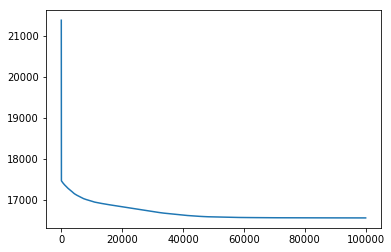

In [85]:
plt.plot(loss_epoch)

### Calculate and print root-mean-squared error and R^2 value for the fit

In [86]:
# Total variance
SSt_SNN = np.sum(np.square(y_test-np.mean(y_test)))
# Residual sum of squares
SSr_SNN = np.sum(np.square(yhat-y_test))
# Root-mean-square error
RMSE_SNN = np.sqrt(np.sum(np.square(yhat-y_test)))
# R^2 coefficient
r2_SNN = 1-(SSr_SNN/SSt_SNN)

print("RMSE error of the shallow neural network:",RMSE_SNN)
print("R^2 value of the shallow neural network:",r2_SNN)

RMSE error of the shallow neural network: 560.110003891
R^2 value of the shallow neural network: 0.0505834181706


### Plot residuals plots

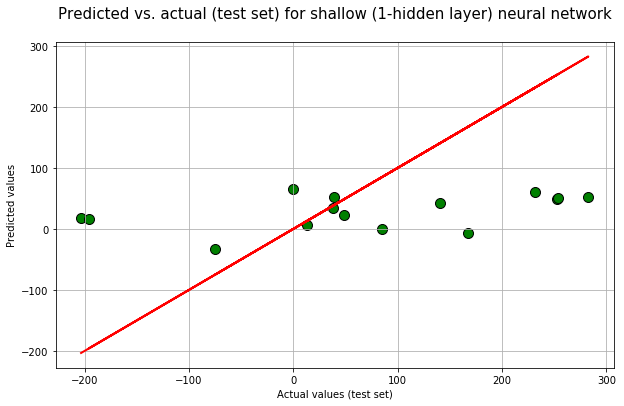

In [87]:
plt.figure(figsize=(10,6))
plt.title("Predicted vs. actual (test set) for shallow (1-hidden layer) neural network\n",fontsize=15)
plt.xlabel("Actual values (test set)")
plt.ylabel("Predicted values")
plt.scatter(y_test,yhat,edgecolors='k',s=100,c='green')
plt.grid(True)
plt.plot(y_test,y_test,'r',lw=2)

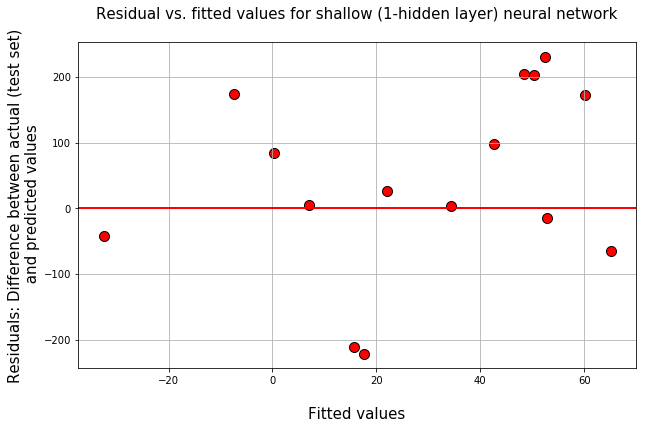

In [88]:
plt.figure(figsize=(10,6))
plt.scatter(yhat,y_test-yhat,edgecolors='k',s=100,c='red')
plt.title("Residual vs. fitted values for shallow (1-hidden layer) neural network\n",fontsize=15)
plt.xlabel("\nFitted values",fontsize=15)
plt.ylabel("Residuals: Difference between actual (test set)\n and predicted values",fontsize=15)
plt.grid(True)
plt.axhline(y=0,lw=2,c='red')

## More hidden layers

### Hyperparameters and layers' variables

In [89]:
learning_rate = 0.00001
training_epochs = 35000

n_input = 1  # Number of features
n_output = 1  # Regression output is a number only

n_hidden_layer_1 = 35 # Hidden layer 1
n_hidden_layer_2 = 35 # Hidden layer 2

### Weights and bias variable

In [90]:
# Store layers weight & bias as Variables classes in dictionaries
weights = {
    'hidden_layer_1': tf.Variable(tf.random_normal([n_input, n_hidden_layer_1])),
    'hidden_layer_2': tf.Variable(tf.random_normal([n_hidden_layer_1, n_hidden_layer_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer_2, n_output]))
}
biases = {
    'hidden_layer_1': tf.Variable(tf.random_normal([n_hidden_layer_1])),
    'hidden_layer_2': tf.Variable(tf.random_normal([n_hidden_layer_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

In [91]:
print("Shape of the weights tensor of hidden layer 1:",weights['hidden_layer_1'].shape)
print("Shape of the weights tensor of hidden layer 2:",weights['hidden_layer_2'].shape)
print("Shape of the weights tensor of output layer:",weights['out'].shape)
print("--------------------------------------------------------")
print("Shape of the bias tensor of hidden layer 1:",biases['hidden_layer_1'].shape)
print("Shape of the bias tensor of hidden layer 2:",biases['hidden_layer_2'].shape)
print("Shape of the bias tensor of output layer:",biases['out'].shape)

Shape of the weights tensor of hidden layer 1: (1, 35)
Shape of the weights tensor of hidden layer 2: (35, 35)
Shape of the weights tensor of output layer: (35, 1)
--------------------------------------------------------
Shape of the bias tensor of hidden layer 1: (35,)
Shape of the bias tensor of hidden layer 2: (35,)
Shape of the bias tensor of output layer: (1,)


### Input data as placeholder

In [92]:
# tf Graph input
x = tf.placeholder("float32", [None,n_input])
y = tf.placeholder("float32", [None,n_output])

### Hidden and output layers definition (using TensorFlow mathematical functions)

In [93]:
# Hidden layer with RELU activation
layer_1 = tf.add(tf.matmul(x, weights['hidden_layer_1']),biases['hidden_layer_1'])
layer_1 = tf.nn.relu(layer_1)

layer_2 = tf.add(tf.matmul(layer_1, weights['hidden_layer_2']),biases['hidden_layer_2'])
layer_2 = tf.nn.relu(layer_2)

# Output layer with linear activation
ops = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])

### Gradient descent optimizer for training (backpropagation)

In [94]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.squared_difference(ops,y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

### TensorFlow Session for training and loss estimation

In [95]:
from tqdm import tqdm
import time
# Initializing the variables
init = tf.global_variables_initializer()

# Empty lists for book-keeping purpose
epoch=0
log_epoch = []
epoch_count=[]
acc=[]
loss_epoch=[]

# Launch the graph and time the session
t1=time.time()
with tf.Session() as sess:
    sess.run(init)    
    # Loop over epochs
    for epoch in tqdm(range(training_epochs)):
        # Run optimization process (backprop) and cost function (to get loss value)
        _,l=sess.run([optimizer,cost], feed_dict={x: X_train, y: y_train})
        loss_epoch.append(l) # Save the loss for every epoch        
        epoch_count.append(epoch+1) #Save the epoch count
       
        # print("Epoch {}/{} finished. Loss: {}, Accuracy: {}".format(epoch+1,training_epochs,round(l,4),round(accu,4)))
        #print("Epoch {}/{} finished. Loss: {}".format(epoch+1,training_epochs,round(l,4)))
    w=sess.run(weights)
    b = sess.run(biases)
    yhat=sess.run(ops,feed_dict={x:X_test})

t2=time.time()
time_DNN = t2-t1

100%|██████████████████████████████████| 35000/35000 [00:16<00:00, 2151.34it/s]


### Plot loss function as training epochs progress

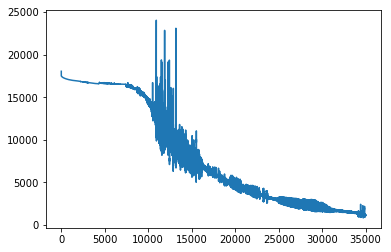

In [96]:
plt.plot(loss_epoch)

### Calculate and print root-mean-squared error and R^2 value for the fit

In [97]:
# Total variance
SSt_DNN = np.sum(np.square(y_test-np.mean(y_test)))
# Residual sum of squares
SSr_DNN = np.sum(np.square(yhat-y_test))
# Root-mean-square error
RMSE_DNN = np.sqrt(np.sum(np.square(yhat-y_test)))
# R^2 coefficient
r2_DNN = 1-(SSr_DNN/SSt_DNN)

print("RMSE error of the deep neural network:",RMSE_DNN)
print("R^2 value of the deep neural network:",r2_DNN)

RMSE error of the deep neural network: 235.822196788
R^2 value of the deep neural network: 0.83170178301


### Plot residuals plots

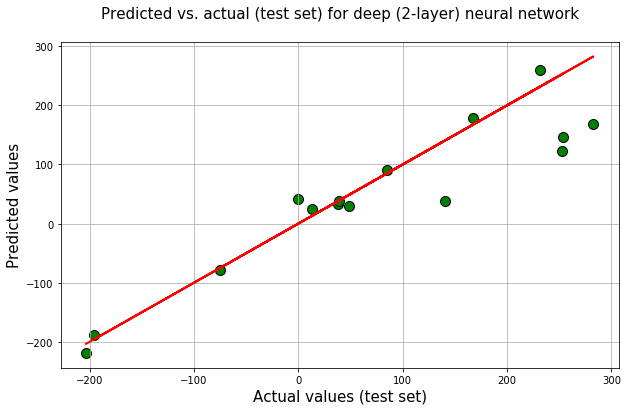

In [98]:
plt.figure(figsize=(10,6))
plt.title("Predicted vs. actual (test set) for deep (2-layer) neural network\n",fontsize=15)
plt.xlabel("Actual values (test set)",fontsize=15)
plt.ylabel("Predicted values",fontsize=15)
plt.scatter(y_test,yhat,edgecolors='k',s=100,c='green')
plt.grid(True)
plt.plot(y_test,y_test,'r',lw=2)

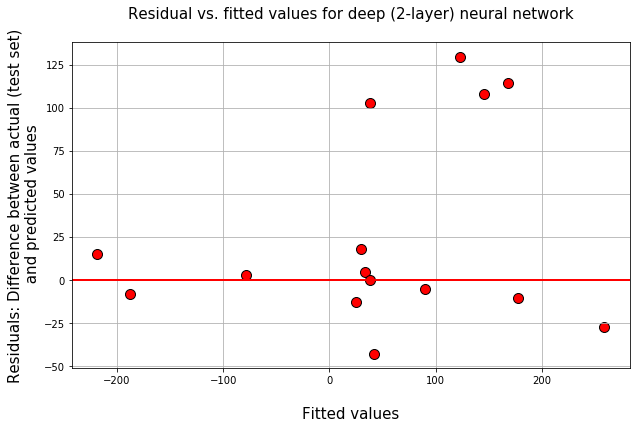

In [99]:
plt.figure(figsize=(10,6))
plt.scatter(yhat,y_test-yhat,edgecolors='k',s=100,c='red')
plt.title("Residual vs. fitted values for deep (2-layer) neural network\n",fontsize=15)
plt.xlabel("\nFitted values",fontsize=15)
plt.ylabel("Residuals: Difference between actual (test set)\n and predicted values",fontsize=15)
plt.grid(True)
plt.axhline(y=0,lw=2,c='red')

## Plot the time taken for model build/fit

<Container object of 3 artists>

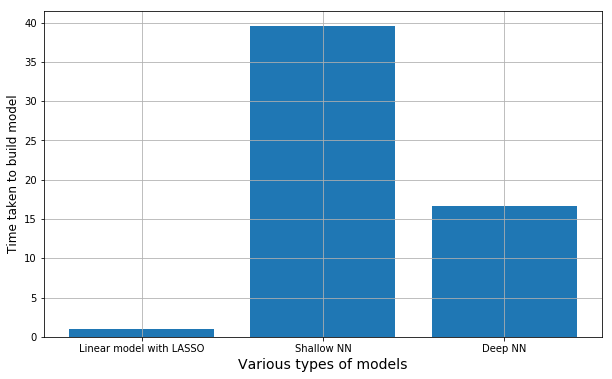

In [100]:
plt.figure(figsize=(10,6))
plt.ylabel("Time taken to build model",fontsize=12)
plt.xlabel("Various types of models",fontsize=14)
plt.grid(True)
plt.bar(left=[1,2,3],height=[time_linear,time_SNN,time_DNN], 
        align='center',tick_label=['Linear model with LASSO','Shallow NN','Deep NN'])

<Container object of 3 artists>

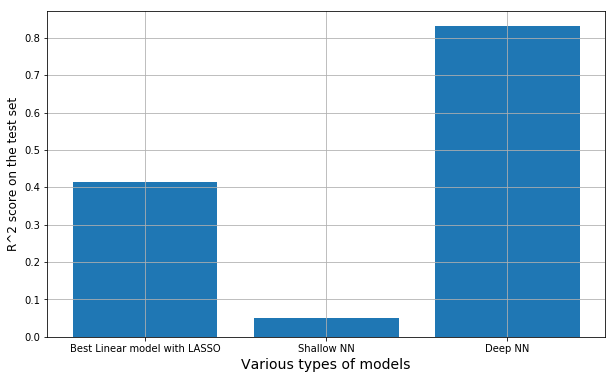

In [101]:
plt.figure(figsize=(10,6))
plt.ylabel("R^2 score on the test set",fontsize=12)
plt.xlabel("Various types of models",fontsize=14)
plt.grid(True)
plt.bar(left=[1,2,3],height=[r2_linear,r2_SNN,r2_DNN], 
        align='center',tick_label=['Best Linear model with LASSO','Shallow NN','Deep NN'])